In [1]:
import tensorflow as tf
import numpy as np
import random
import glob
import cv2
import matplotlib.pyplot as plt
import pickle

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Set parameters
image_height = 32
image_width = 32
num_channels = 3
num_categories = 10
num_filters1 = 32
num_filters2 = 64
num_filters3 = 64
num_filters4 = 128
num_filters5 = 256
filter_size = 3
num_epochs = 10
batch_size = 10
is_plot = 1
pooling_size = 2
fully_connected_size = 1024
learning_rate = .0005

In [3]:
# Read CIFAR training data
train_data = None
train_labels = None
for file_index in range(5):
    train_file = open('data/cifar-10-batches-py/data_batch_' + str(file_index+1), 'rb')
    train_dict = pickle.load(train_file, encoding='latin1')
    train_file.close()
    if train_data is None:
        train_data = np.array(train_dict['data'], float)/255.0
        train_labels = train_dict['labels']
    else:
        train_data = np.concatenate((train_data, train_dict['data']), 0)
        train_labels = np.concatenate((train_labels, train_dict['labels']), 0)

In [7]:
print(np.shape(train_labels), np.shape(train_data))
train_data = train_data.reshape([-1, num_channels, image_height, image_width])
train_data = train_data.transpose([0, 2, 3, 1])
train_labels = np.eye(num_categories)[train_labels]
print(np.shape(train_data))
print(np.shape(train_labels))

(50000,) (50000, 3072)
(50000, 32, 32, 3)
(50000, 10)


In [8]:
# Read CIFAR test data
test_file = open('data/cifar-10-batches-py/test_batch', 'rb')
test_dict = pickle.load(test_file, encoding='latin1')
test_file.close()
test_data = test_dict['data']
test_labels = test_dict['labels']

In [9]:
# Preprocess test data and labels
test_data = test_data.reshape([-1, num_channels, image_height, image_width])
test_data = test_data.transpose([0, 2, 3, 1])
test_labels = np.eye(num_categories)[test_labels]
print(np.shape(test_data))
print(np.shape(test_labels))

(10000, 32, 32, 3)
(10000, 10)


In [10]:
# images plotting function
def plotImg(imgs, titles = None):
    fig = plt.figure()
    for i in range(len(imgs)):
        ax = fig.add_subplot(1, len(imgs), i + 1)
        if titles != None:
            ax.title.set_text(titles[i])
        plt.imshow(imgs[i])
        plt.axis('off')
    plt.show()

In [11]:
# Placeholders for images
img_holder = tf.placeholder(tf.float32, [None, image_height, image_width,
num_channels], name = 'img_holder')
lbl_holder = tf.placeholder(tf.int8, [None, num_categories], name = 'lbl_holder')
train = tf.placeholder(tf.bool, name = 'train_bool')

In [12]:
# Preprocess the image, Performs random transformations
# Random flip left and right
img_tensor_flip = tf.map_fn(lambda img: tf.image.random_flip_left_right(img), img_holder)
# Random flip up and down 
img_tensor_flip1 = tf.map_fn(lambda img: tf.image.random_flip_up_down(img), img_tensor_flip)
# Random brightness
img_tensor_bri = tf.map_fn(lambda img: tf.image.random_brightness(img, max_delta=0.2), img_tensor_flip1)
# Per-image scaling
img_tensor_std = tf.map_fn(lambda img: tf.image.per_image_standardization(img), img_tensor_bri)

In [13]:
# Create convolution/pooling layers
conv1 = tf.layers.conv2d(img_tensor_std, num_filters1, filter_size, padding='same', \
activation=tf.nn.relu, name = 'conv1')
print(np.shape(img_tensor_std))
print(np.shape(conv1))

(?, 32, 32, 3)
(?, 32, 32, 32)


In [14]:
pool1 = tf.layers.max_pooling2d(conv1, pooling_size, pooling_size, name = 'pool1')
print(np.shape(pool1))

(?, 16, 16, 32)


In [15]:
conv2 = tf.layers.conv2d(pool1, num_filters2, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv2')

In [16]:
pool2 = tf.layers.max_pooling2d(conv2, pooling_size, pooling_size, name = 'pool2')
print(np.shape(pool2))

(?, 8, 8, 64)


In [17]:
conv3 = tf.layers.conv2d(pool2, num_filters3, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv3')

In [18]:
pool3 = tf.layers.max_pooling2d(conv3, pooling_size, pooling_size, name = 'pool3')
print(np.shape(pool3))

(?, 4, 4, 64)


In [19]:
conv4 = tf.layers.conv2d(pool3, num_filters4, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv4')

In [20]:
conv5 = tf.layers.conv2d(conv4, num_filters5, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv5')

In [21]:
pool4 = tf.layers.max_pooling2d(conv5, pooling_size, pooling_size, name = 'pool4')
print(np.shape(pool4))

(?, 2, 2, 256)


In [22]:
# Flatten input data
flatten = tf.reshape(pool4, [-1, fully_connected_size], name = 'flatten')
print(np.shape(flatten))

(?, 1024)


In [23]:
# Create connected layers
with tf.contrib.framework.arg_scope(
[tf.contrib.layers.fully_connected],
normalizer_fn=tf.contrib.layers.batch_norm,
normalizer_params={'is_training': train}):
    fc1 = tf.contrib.layers.fully_connected(flatten, fully_connected_size, scope = 'fc1')
    fc2 = tf.contrib.layers.fully_connected(fc1, num_categories,
    activation_fn=None, scope = 'fc2')

In [24]:
print(np.shape(fc2))

(?, 10)


In [25]:
# Compute loss
loss = tf.reduce_mean(
tf.nn.softmax_cross_entropy_with_logits(
logits=fc2, labels=lbl_holder), name = 'loss')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [26]:
# Create optimizer
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, name = 'optimizer', global_step = global_step)

In [27]:
# Determine success rate
prediction = tf.argmax(fc2, 1, name = 'prediction')
correct_pred = tf.equal(prediction, tf.argmax(lbl_holder, 1), name = 'correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name = 'accuracy')
# probabilities of each class
probabilities = tf.nn.softmax(fc2, name='probabilities')

In [28]:
# Initialize variables
init = tf.global_variables_initializer()
# Launch session
sess = tf.Session()
sess.run(init)
# saver for storing training result
saver = tf.train.Saver()

In [29]:
print(np.shape(train_data))

(50000, 32, 32, 3)


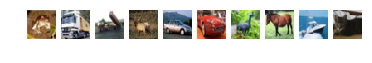

In [31]:
plotImg(train_data[0:10])

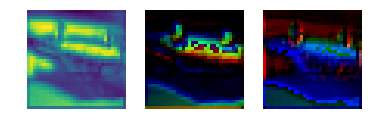

In [32]:
if is_plot:
    dataConv1 = sess.run(conv1, feed_dict = {img_holder: [train_data[4]]})
    plotImg([np.mean(dataConv1[0], axis = 2),dataConv1[:,:,:,0:3][0],dataConv1[:,:,:,-4:-1][0]])

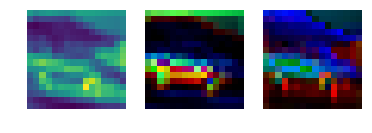

In [33]:
if is_plot:
    dataPool1 = sess.run(pool1, feed_dict = {img_holder: [train_data[4]], train: False})
    plotImg([np.mean(dataPool1[0], axis = 2),dataPool1[:,:,:,0:3][0],dataPool1[:,:,:,-4:-1][0]])

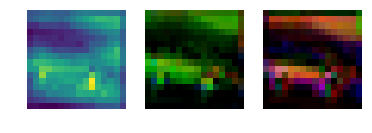

In [34]:
if is_plot:
    dataConv2 = sess.run(conv2, feed_dict = {img_holder: [train_data[4]], train: False})
    plotImg([np.mean(dataConv2[0], axis = 2),dataConv2[:,:,:,0:3][0],dataConv2[:,:,:,-4:-1][0]])

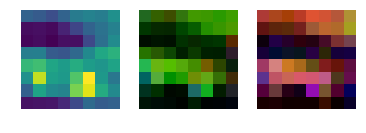

In [35]:
if is_plot:
    dataPool2 = sess.run(pool2, feed_dict = {img_holder: [train_data[4]], train: False})
    plotImg([np.mean(dataPool2[0], axis = 2),dataPool2[:,:,:,0:3][0],dataPool2[:,:,:,-4:-1][0]])

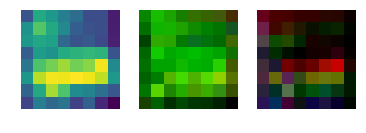

In [36]:
if is_plot:
    dataConv3 = sess.run(conv3, feed_dict = {img_holder: [train_data[4]], train: False})
    plotImg([np.mean(dataConv3[0], axis = 2),dataConv3[:,:,:,0:3][0],dataConv3[:,:,:,-4:-1][0]])

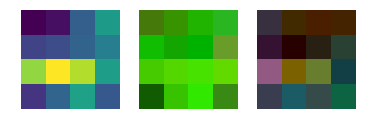

In [37]:
if is_plot:
    dataPool3 = sess.run(pool3, feed_dict = {img_holder: [train_data[4]], train: False})
    plotImg([np.mean(dataPool3[0], axis = 2),dataPool3[:,:,:,0:3][0],dataPool3[:,:,:,-4:-1][0]])

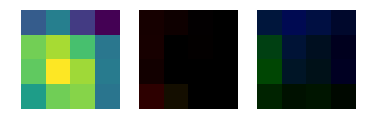

In [38]:
if is_plot:
    dataConv4 = sess.run(conv4, feed_dict = {img_holder: [train_data[4]], train: False})
    plotImg([np.mean(dataConv4[0], axis = 2),dataConv4[:,:,:,0:3][0],dataConv4[:,:,:,-4:-1][0]])

(1, 4, 4, 256)


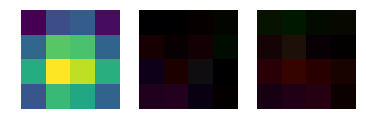

In [39]:
if is_plot:
    dataConv5 = sess.run(conv5, feed_dict = {img_holder: [train_data[4]], train: False})
    print(np.shape(dataConv5))
    plotImg([np.mean(dataConv5[0], axis = 2),dataConv5[:,:,:,0:3][0],dataConv5[:,:,:,-4:-1][0]])

(1, 2, 2, 256)


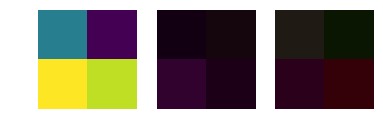

In [40]:
if is_plot:
    dataPool4 = sess.run(pool4, feed_dict = {img_holder: [train_data[4]], train: False})
    print(np.shape(dataPool4))
    plotImg([np.mean(dataPool4[0], axis = 2),dataPool4[:,:,:,0:3][0],dataPool4[:,:,:,-4:-1][0]])

In [41]:
num_batches = int(50000/batch_size)
# Launch session
# Loop over epochs
for epoch in range(num_epochs):
    # Loop over batches
    for batch in range(num_batches):
        batch_start = random.randint(0, batch_size*(num_batches-1)-1)
        batch_end = batch_start + batch_size
        img_batch = train_data[batch_start:batch_end, :]
        lbl_batch = train_labels[batch_start:batch_end, :]
        sess.run(optimizer, feed_dict={img_holder: img_batch, \
        lbl_holder: lbl_batch, train: True})
    accuracy_val = sess.run(accuracy, feed_dict={img_holder: test_data, lbl_holder: test_labels, train: False})
    print('epoch:', epoch+1,'Accuracy:', accuracy_val)

epoch: 1 Accuracy: 0.3148
epoch: 2 Accuracy: 0.4861


KeyboardInterrupt: 